- Trong bài này chúng ta sẽ xem mô hình ta thực hiện tốt ra sao? các cách đánh giá mô hình?
    - Từ trước ta biết đến accuracy = số phân loại đúng/ tổng mẫu phân loại
    - Có nhiều cách để đánh giá mô hình khác, chúng ta cùng xem confution matrix, cách trực quan với ROC cuvre, đánh giá mô hình với AUC
- Tiếp theo ta sẽ xem cách điều chỉnh các siêu tham số cho mô hình

Tham khảo: [Confusion matrix and other metrics in machine learning](https://medium.com/hugo-ferreiras-blog/confusion-matrix-and-other-metrics-in-machine-learning-894688cb1c0a#:~:text=The%20confusion%20matrix%20is%20another,performance%20of%20a%20classification%20algorithm.&text=The%20predicted%20classes%20are%20represented,the%20rows%20of%20the%20matrix.)

Nguồn dữ liệu diabetes: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd

diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
X = diabetes.drop('Outcome', axis =1).values
y = diabetes['Outcome'].values
print(X.shape, y.shape)

(768, 8) (768,)


- Chúng ta xem các thước đo đánh giá mô hình:

<img src = 'https://i.imgur.com/H3Jwf4y.jpg'>

<img src = 'https://i.imgur.com/mVHBwqK.jpg'>


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state= 42)

knn = KNeighborsClassifier(10) #phân cụm với 10 neibghor
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred)) # confusion matrix
print(classification_report(y_test, y_pred)) #precision, recall, F1score


[[127  24]
 [ 41  39]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       151
           1       0.62      0.49      0.55        80

    accuracy                           0.72       231
   macro avg       0.69      0.66      0.67       231
weighted avg       0.71      0.72      0.71       231



Ở trên ta đã thực hiện với phân cụm, bây giờ ta sử dụng mô hình logistic regression và xem nó có tốt hơn so với phân cụm hay không!

Ta thêm 'solver='lbfgs', max_iter=1000 'để không bị hiện các dóng sau khi chạy mô hình: 'lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.'


In [4]:
from sklearn.linear_model import LogisticRegression

logis = LogisticRegression(solver='lbfgs', max_iter=1000)
logis.fit(X_train, y_train)
y_pred = logis.predict(X_test)

print(confusion_matrix(y_test, y_pred)) # confusion matrix
print(classification_report(y_test, y_pred)) #precision, recall, F1score

[[120  31]
 [ 30  50]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



Trực quan hóa với ROC curev:
- Khi thresholds = 0, tất cả email đều được phân loại là thực
- Khi thresholds = 1, tất cả email đều phân loại là spam
- Với thresholds ở mô hình (mặc định là 0.5), ta vẽ biểu đồ biểu thị email spam được phân loại đúng(tpr); và email thực bị phân loại sai (fpr). Phần diện tích dưới đường này càng gần 1 thì mô hình càng có độ chính xác cao.

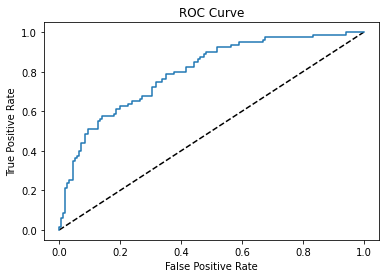

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_pred_prob = logis.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Trực quan hóa với Precision-recall curve

0.6666682373339652


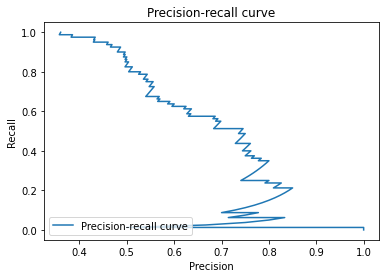

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

print(average_precision_score(y_test, y_pred_prob))

plt.plot(precision, recall, label='Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve')
plt.legend(loc="lower left")

Tính diện tích phần dưới ROC-curve : AUC (Area under the ROC curve)

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logis, X, y, cv =5, scoring = 'roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.796523178807947
AUC scores computed using 5-fold cross-validation: [0.81240741 0.80777778 0.82555556 0.87283019 0.84490566]


Điều chỉnh siêu tham số:
- Siêu tham số alpha của Lasso, Ridge
- k-neighbor của phân cụm
- Chúng ta thực hiện lựa chọn siêu tham số cùng xác thực chéo

Ta sẽ điều chỉnh tham số C của mô hình logistics regression. C kiểm soát nghịch đảo của regulrization; C lớn --> overfit; C bé --> underfit
 
Xem thêm: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [8]:
from sklearn.model_selection import GridSearchCV

c_space = np.logspace(-5, 8, 15) # chọn 15 mẫu C từ 10^-5 đến 10^8
param_grid = {'C': c_space}

logis_cv = GridSearchCV(logis, param_grid, cv= 5)
logis_cv.fit(X,y)

print("Tuned Logistic Regression Parameters: {}".format(logis_cv.best_params_)) 
print("Best score is {}".format(logis_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.006105402296585327}
Best score is 0.7734742381801205


GridSearchCV sẽ tốn nhiều chi phí tính toán, chúng ta sử dụng RandomizedSearchCV: nó sẽ lấy mẫu siêu tham số từ 1 phân phối xác suất được chỉ định.  
Tham khảo thêm về [scipy.stats.randint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)  
Tham khảo thêm về [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [9]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv= 5)
tree_cv.fit(X,y)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1}
Best score is 0.7291656056361939


In [10]:
c_space = np.logspace(-5, 8, 15) # chọn 15 mẫu C từ 10^-5 đến 10^8
param_grid = {'C': c_space, 'penalty' : ['l1', 'l2']}

logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_cv = GridSearchCV(logreg, param_grid, cv =5)
logreg_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 3.727593720314938, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7764797507788161


Điều chình siêu tham số ElasticNet  
Tham khảo: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

In [41]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
l1_space = np.linspace(0, 1, 30)[1:]
param_grid = {'l1_ratio': l1_space}

elastic_net = ElasticNet()
gm_cv = GridSearchCV(elastic_net, param_grid, cv= 5)

gm_cv.fit(X_train, y_train)
y_pred = gm_cv.predict(X_test)

r2 = gm_cv.score(X_test , y_test)
mse = mean_squared_error(y_test , y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet best score: {}".format(gm_cv.best_score_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.034482758620689655}
Tuned ElasticNet best score: 0.27054802005300305
Tuned ElasticNet R squared: 0.24416427350671188
Tuned ElasticNet MSE: 0.16741461761128532
